**Задача**:

В июле провели специальную акцию, направленную на улучшение ретеншена. Новым юзерам слали письмо с купоном. Сработала ли акция?

#Загрузим данные

https://drive.google.com/file/d/1lGGKzADgGRBvFnzqfLdrticS1D5wKMzk/view?usp=sharing

In [1]:
! gdown --id 1lGGKzADgGRBvFnzqfLdrticS1D5wKMzk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lGGKzADgGRBvFnzqfLdrticS1D5wKMzk
To: /content/analyst_test_transactions_db.csv
100% 3.07M/3.07M [00:00<00:00, 21.7MB/s]


#Посмотрим на данные

Будем работать больше с SQL

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 # импортируем базу данных

plt.style.use('dark_background')

In [3]:
sqlite3.sqlite_version

'3.37.2'

In [4]:
con = sqlite3.connect("db") # подключаемся к базе данных

def select(sql: str) -> pd.DataFrame:
  """ Промежуточная функция для выборки данных из СУБД SQLite """
  return pd.read_sql(sql, con)

In [5]:
t = pd.read_csv("/content/analyst_test_transactions_db.csv")
t.head(5)

,user_id,order_id,reg_date,transaction_date,revenue
0,57562,94545.0,2013-12-22,2015-07-16,1088
1,40047,81824.0,2013-11-24,2015-01-19,1027
2,48153,144851.0,2015-07-03,2015-10-29,601
3,54591,116111.0,2013-07-12,2015-04-30,881
4,39789,134943.0,2013-05-25,2015-07-21,984


In [6]:
t.groupby('reg_date')['user_id'].agg({'count'}).reset_index()
# -> 1900-01-01 есть в оригинальном датасете

,reg_date,count
0,1900-01-01,53
1,2012-02-24,2
2,2012-02-27,3
3,2012-02-29,4
4,2012-03-01,25
...,...,...
1358,2015-11-16,34
1359,2015-11-17,22
1360,2015-11-18,28
1361,2015-11-19,28


In [7]:
# Дата в виде строки
t['transaction_date'][0]

'2015-07-16'

In [8]:
# Поправили дату
t['transaction_date'] = pd.to_datetime(t['transaction_date'], format='%Y-%m-%d')
t['transaction_date'][0]

Timestamp('2015-07-16 00:00:00')

In [9]:
t.to_sql("data_clients", con, index=False, if_exists='replace')

76857

# Проверка контрольной суммы при загрузке данных в базу данных

In [10]:
t['user_id'].count()

76857

In [11]:
sql = '''
select count(1)
from data_clients t
'''

select(sql)

,count(1)
0,76857


# Проведем анализ данных, которые мы загрузили (EDA)

In [12]:
sql = '''
select strftime('%Y-%m-01', t.reg_date) as date_all, count(user_id) as count_user
from data_clients t
group by 1
having count(strftime('%Y-%m-01', t.reg_date)) < 1000
'''
t = select(sql)
# Количество зарегистрированных пользователей по месяцам
t

,date_all,count_user
0,1900-01-01,53
1,2012-02-01,9
2,2012-03-01,362
3,2012-04-01,370
4,2012-05-01,301
5,2012-06-01,445
6,2012-07-01,370
7,2012-08-01,271
8,2012-09-01,356
9,2012-10-01,367


In [13]:
sql = '''
select count(distinct t.user_id)
from data_clients t
'''

# количество уникальных пользователей
select(sql)

,count(distinct t.user_id)
0,48214


In [14]:
sql = '''
select count(distinct t.order_id)
from data_clients t
'''

# количество уникальных заказов
select(sql)

,count(distinct t.order_id)
0,76857


Получается, что есть одинаковые пользователи и для каждого даже повторяющегося пользователся присваивается новый заказ

Посмотрим сколько пользователей регистрировалось за каждый месяц, для этого подготовим аналитическую таблицу, чтобы не потерять все даты за период


In [15]:
# все, кроме 1900 года, так как тогда мы создавали бы таблицу для 100+ лет, а 1 января 1900 года было почти меньше всех новых юзеров за период
sql = '''
select
min(strftime('2012-01-01', t.reg_date)) as min_date,
max(strftime('%Y-%m-01', t.reg_date)) as max_date
from data_clients t
'''

min_date = select(sql)['min_date'][0]
max_date = select(sql)['max_date'][0]

print(min_date, "-", max_date)

2012-01-01 - 2015-11-01


Получили диапазон дат, создадим таблицу на основе этого диапазона - аналог CALENDARAUTO() в PowerBI

In [16]:
data_range = pd.DataFrame(pd.date_range(min_date, max_date))
data_range.columns = ['dates']

In [17]:
t.columns = ['dates', 'count_user']
t['dates'] = pd.to_datetime(t['dates'])

In [18]:
# Теперь к нас есть таблица со всеми данными за каждый день за период - аналитическая таблица
t_date = data_range.merge(t, how='left').fillna(0)
t_date

,dates,count_user
0,2012-01-01,0.0
1,2012-01-02,0.0
2,2012-01-03,0.0
3,2012-01-04,0.0
4,2012-01-05,0.0
...,...,...
1396,2015-10-28,0.0
1397,2015-10-29,0.0
1398,2015-10-30,0.0
1399,2015-10-31,0.0


<BarContainer object of 1401 artists>

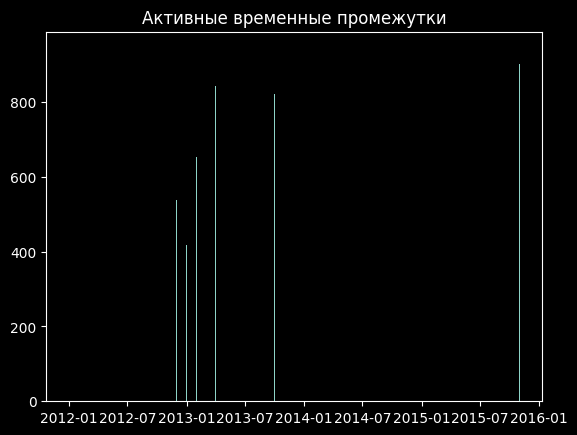

In [19]:
x = t_date['dates']
y = t_date['count_user']

plt.title("Активные временные промежутки")
plt.bar(x, y)

In [20]:
t_date['year_only'] = t_date['dates'].dt.year

<Axes: xlabel='year_only'>

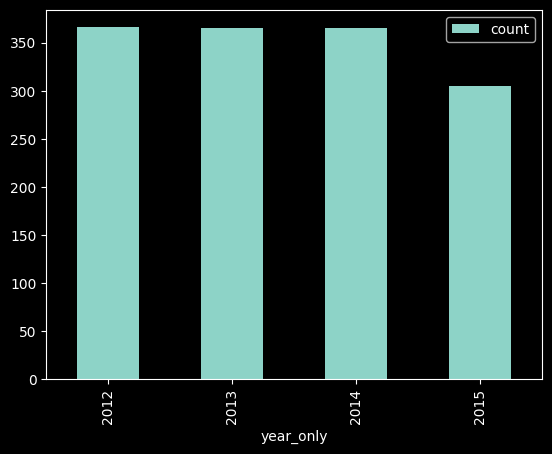

In [21]:
t_date.groupby('year_only')['count_user'].agg({'count'}).plot(kind='bar')

У нас есть отрицательные значения user_id (вряд ли мы сможем для удобства сделать user_id положительными, поскольку возможно это правила предметной области)

<Axes: ylabel='Frequency'>

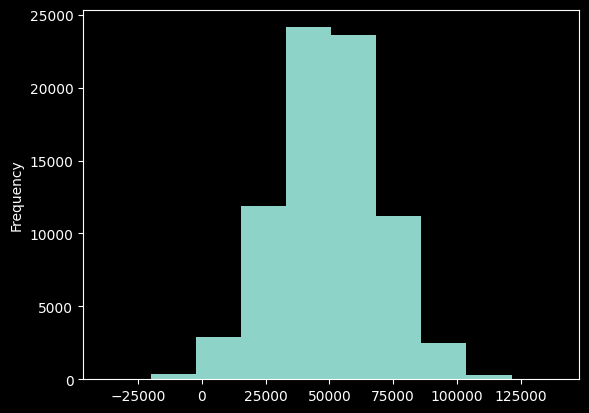

In [22]:
sql = '''
select t.*
from data_clients t
'''

data_all = select(sql)

data_all['user_id'].plot(kind='hist')

<Axes: ylabel='Frequency'>

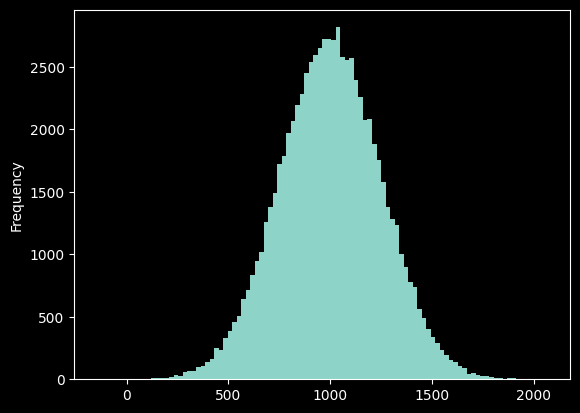

In [23]:
data_all['revenue'].plot(kind='hist', bins=100)

Перейдем к сути задачи: нам нужно определить как сработала новая акция, запущенная в июле (скорее всего 2015 года, так как письмо слали новым юзерам), чтобы понять сработала акция или нет - нам нужно это с чем-то сравнивать (голые результаты ничего не дадут), поэтому посмотрим на ретеншен, который был годами ранее

Для этого мы должны собрать аналитическую табличку (некоторую заготовку) для пользователей по датам.

In [24]:
sql = '''
select t.*
from data_clients t
'''

data_all = select(sql)

# на каждого пользователя у нас есть есть дата его регистрации и дата транзакции (groupby, чтобы оставить только уникальных пользователей)
data_user = data_all.groupby('user_id')[['reg_date', 'transaction_date']].min().reset_index()

In [25]:
data_user['key'] = 1
data_user

,user_id,reg_date,transaction_date,key
0,-37599,2015-01-19,2015-03-06 00:00:00,1
1,-32239,2015-11-05,2015-11-06 00:00:00,1
2,-29822,2015-07-31,2015-09-14 00:00:00,1
3,-29531,2014-09-07,2015-06-13 00:00:00,1
4,-25337,2015-04-10,2015-07-31 00:00:00,1
...,...,...,...,...
48209,128964,2015-10-18,2015-10-23 00:00:00,1
48210,130617,2015-02-04,2015-06-28 00:00:00,1
48211,131071,2012-04-18,2015-10-28 00:00:00,1
48212,132484,2015-06-12,2015-08-14 00:00:00,1


In [26]:
data_range['key'] = 1
template = data_range.merge(data_user, how='inner', on='key')

In [27]:
template = template[['dates', 'user_id', 'reg_date', 'transaction_date']]

Таким образом, у нас на каждого пользователя есть все возмонжные даты активностей за период, дата регистрации и дата транзакции все возможные за период, то есть мы теперь сможем понять в какие дни пользователь был активным, а в какие дни он не был активным вообще за период и сможем получить точное число благодаря подготовленной аналитической таблице. Ниже можно посмотреть все на примере одного пользователя

In [28]:
template[template['user_id']==131071]

,dates,user_id,reg_date,transaction_date
48211,2012-01-01,131071,2012-04-18,2015-10-28 00:00:00
96425,2012-01-02,131071,2012-04-18,2015-10-28 00:00:00
144639,2012-01-03,131071,2012-04-18,2015-10-28 00:00:00
192853,2012-01-04,131071,2012-04-18,2015-10-28 00:00:00
241067,2012-01-05,131071,2012-04-18,2015-10-28 00:00:00
...,...,...,...,...
67354955,2015-10-28,131071,2012-04-18,2015-10-28 00:00:00
67403169,2015-10-29,131071,2012-04-18,2015-10-28 00:00:00
67451383,2015-10-30,131071,2012-04-18,2015-10-28 00:00:00
67499597,2015-10-31,131071,2012-04-18,2015-10-28 00:00:00


Теперь давайте подтянем выручку

In [29]:
data_all

,user_id,order_id,reg_date,transaction_date,revenue
0,57562,94545.0,2013-12-22,2015-07-16 00:00:00,1088
1,40047,81824.0,2013-11-24,2015-01-19 00:00:00,1027
2,48153,144851.0,2015-07-03,2015-10-29 00:00:00,601
3,54591,116111.0,2013-07-12,2015-04-30 00:00:00,881
4,39789,134943.0,2013-05-25,2015-07-21 00:00:00,984
...,...,...,...,...,...
76852,36921,163682.0,2015-01-15,2015-03-28 00:00:00,1095
76853,31360,145146.0,2015-01-04,2015-08-09 00:00:00,547
76854,56195,8929.0,2012-09-18,2015-11-12 00:00:00,850
76855,46362,78673.0,2015-02-20,2015-07-21 00:00:00,356


In [30]:
user_revenue = data_all.groupby(['user_id', 'reg_date', 'transaction_date'])['revenue'].sum().reset_index()

In [31]:
user_revenue

,user_id,reg_date,transaction_date,revenue
0,-37599,2015-01-19,2015-03-06 00:00:00,1182
1,-32239,2015-11-05,2015-11-06 00:00:00,727
2,-29822,2015-07-31,2015-09-14 00:00:00,908
3,-29531,2014-09-07,2015-06-13 00:00:00,1462
4,-25337,2015-04-10,2015-07-31 00:00:00,899
...,...,...,...,...
76852,128964,2015-10-18,2015-10-23 00:00:00,1049
76853,130617,2015-02-04,2015-06-28 00:00:00,1295
76854,131071,2012-04-18,2015-10-28 00:00:00,856
76855,132484,2015-06-12,2015-08-14 00:00:00,747


Проверим контрольные суммы

In [32]:
data_all['revenue'].sum()

76902158

In [33]:
user_revenue['revenue'].sum()

76902158

Все ок, так как мы заменили NaN на 0. В Collab'е ограничение на ОЗУ в 12 Гб, поэтому выручку мы подтянуть не сможем к аналитической таблице.

In [34]:
t = user_revenue.groupby('transaction_date')['revenue'].agg({'sum'}).reset_index()
t.columns = ['transaction_date', 'revenue_date']
t['transaction_date'] = pd.to_datetime(t['transaction_date'])
t['transaction_date_month'] = t['transaction_date'].dt.month
t

,transaction_date,revenue_date,transaction_date_month
0,2015-01-01,136796,1
1,2015-01-02,99032,1
2,2015-01-03,118204,1
3,2015-01-04,106580,1
4,2015-01-05,102382,1
...,...,...,...
319,2015-11-16,368201,11
320,2015-11-17,343257,11
321,2015-11-18,376876,11
322,2015-11-19,419087,11


В данных есть транзакции только на 2015 год. Посмотрим на динамику выручки этого года.

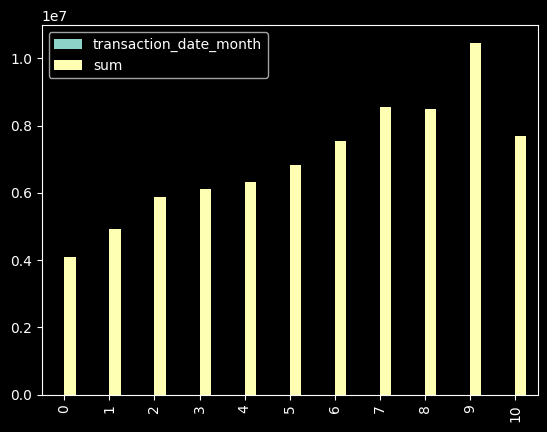

In [35]:
t_sum = t[['transaction_date_month', 'revenue_date']].groupby('transaction_date_month')['revenue_date'].agg({'sum'}).reset_index().plot(kind='bar')

Видим, что самый прибыльный месяц - это 9. Вернемя к задаче.

In [36]:
# Наша заготовка для решения задачи
template['year'] = template['dates'].dt.year
template_2015 = template[template['year']==2015].reset_index()

In [37]:
template_2015['reg_date'] = pd.to_datetime(template_2015['reg_date'])
template_2015['transaction_date'] = pd.to_datetime(template_2015['transaction_date'])

In [38]:
template_2015['day_distance'] = template_2015['transaction_date'] - template_2015['reg_date']

In [39]:
template_2015

,index,dates,user_id,reg_date,transaction_date,year,day_distance
0,52842544,2015-01-01,-37599,2015-01-19,2015-03-06,2015,46 days
1,52842545,2015-01-01,-32239,2015-11-05,2015-11-06,2015,1 days
2,52842546,2015-01-01,-29822,2015-07-31,2015-09-14,2015,45 days
3,52842547,2015-01-01,-29531,2014-09-07,2015-06-13,2015,279 days
4,52842548,2015-01-01,-25337,2015-04-10,2015-07-31,2015,112 days
...,...,...,...,...,...,...,...
14705265,67547809,2015-11-01,128964,2015-10-18,2015-10-23,2015,5 days
14705266,67547810,2015-11-01,130617,2015-02-04,2015-06-28,2015,144 days
14705267,67547811,2015-11-01,131071,2012-04-18,2015-10-28,2015,1288 days
14705268,67547812,2015-11-01,132484,2015-06-12,2015-08-14,2015,63 days


График Retention по всем когортам за 2015 год

<Axes: xlabel='day_distance'>

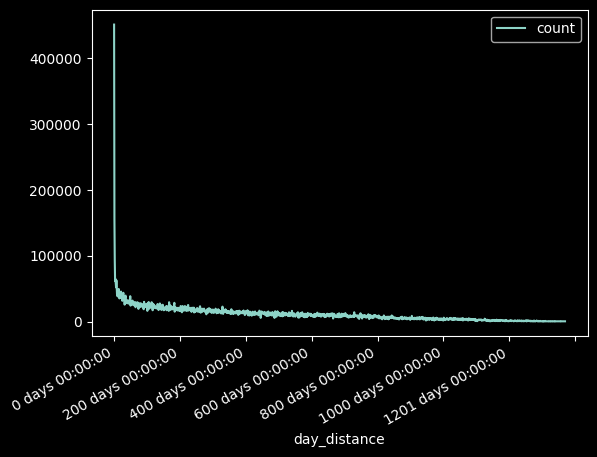

In [40]:
template_2015.groupby('day_distance')['user_id'].agg({'count'}).plot()

Когорта Retention по месяцам: 6, 7, 8, где 7 месяц - это месяц, когда провели акцию

In [72]:
template_2015['dates_month'] = template_2015['dates'].dt.month

In [77]:
tmp_retention = template_2015.query('dates_month == 6 | dates_month == 7 | dates_month == 8 | dates_month == 9')

In [78]:
tmp_retention = tmp_retention.groupby(['dates_month', 'day_distance'])['user_id'].agg({'count'}).reset_index()

In [79]:
tmp_retention

,dates_month,day_distance,count
0,6,0 days,44340
1,6,1 days,15300
2,6,2 days,9210
3,6,3 days,6030
4,6,4 days,6360
...,...,...,...
5475,9,42176 days,30
5476,9,42177 days,30
5477,9,42183 days,30
5478,9,42198 days,30


<Axes: xlabel='day_distance', ylabel='count'>

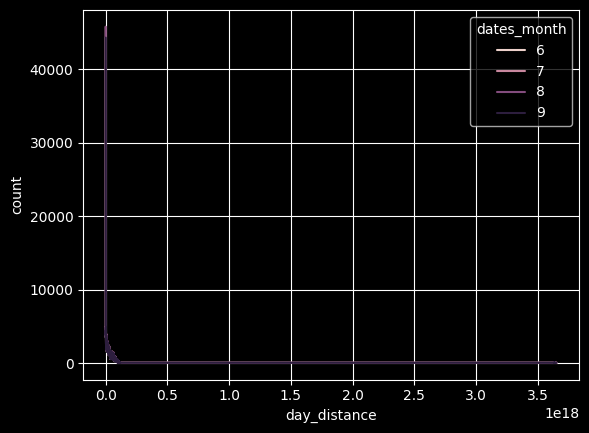

In [80]:
sns.lineplot(x='day_distance', y='count', hue='dates_month', data=tmp_retention, linewidth = 1.5)

По графику видно, что Renetion 7 месяца чуть больше, чем 9 и 8.

In [87]:
t = tmp_retention.pivot_table(index='day_distance', columns='dates_month', values='count', aggfunc='mean').head(100)
t

dates_month,6,7,8,9
day_distance,,,,
0 days,44340,45818,45818,44340
1 days,15300,15810,15810,15300
2 days,9210,9517,9517,9210
3 days,6030,6231,6231,6030
4 days,6360,6572,6572,6360
...,...,...,...,...
95 days,2190,2263,2263,2190
96 days,2370,2449,2449,2370
97 days,2550,2635,2635,2550


<Axes: xlabel='dates_month', ylabel='day_distance'>

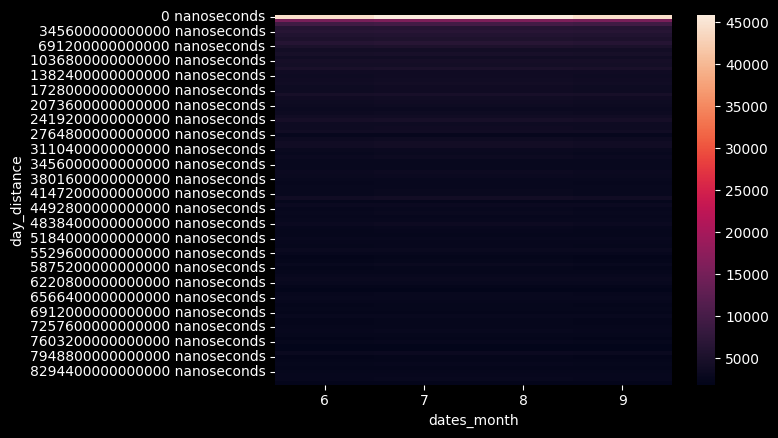

In [88]:
sns.heatmap(t)

По pivot table видно небольшое увеличение на Retention 100 дня в период июльской акции по когорте пользователей на 7 месяц. На heatmap это видно не очень хорошо.

Рассмотрим Retention по когортам в разрезе каждого года с 2012

In [44]:
template['transaction_date'] = pd.to_datetime(template['transaction_date'])
template['reg_date'] = pd.to_datetime(template['reg_date'])

In [45]:
template['day_distance'] = template['transaction_date'] - template['reg_date']

In [46]:
cohort_year_retention = template.groupby(['year', 'day_distance'])['user_id'].agg({'count'}).reset_index()

In [47]:
cohort_year_retention.columns = ['year', 'day_distance', 'count_user']

In [48]:
cohort_year_retention

,year,day_distance,count_user
0,2012,0 days,540948
1,2012,1 days,186660
2,2012,2 days,112362
3,2012,3 days,73566
4,2012,4 days,77592
...,...,...,...
5475,2015,42176 days,305
5476,2015,42177 days,305
5477,2015,42183 days,305
5478,2015,42198 days,305


<Axes: xlabel='day_distance', ylabel='count_user'>

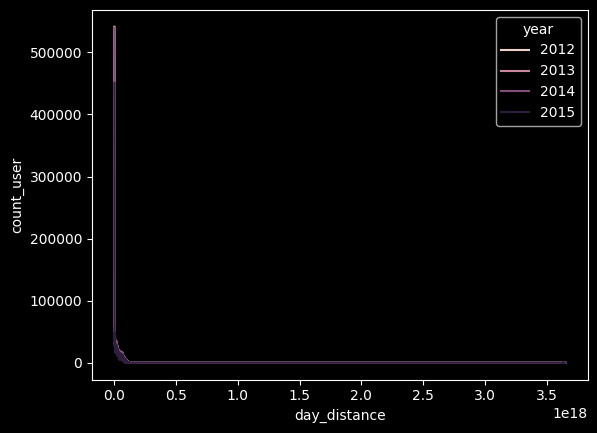

In [49]:
sns.lineplot(x='day_distance', y='count_user', hue='year', data=cohort_year_retention)